# Import Packages

In [ ]:
import os
import pickle

# To see the progress
from tqdm.notebook import tqdm
#  from tqdm import tqdm # for VSCODE, PYCHARM...OTHER "".py" BASED IDE.

import numpy as np

# For visualization
import matplotlib.pyplot as plt

# Things related to the pytorch
import torch                                        # main pytorch package
import torch.nn as nn                               # pytorch module for neural network
from torch.utils.data import Dataset, DataLoader    # pytorch utils for dataset

# Make the dataset! add noise to the linear function
- gt_w, gt_b : ground truth weight and bias for linear regression
- x : random points
- y : gt_w * x + gt_b + (gaussian) noise

In [ ]:
### To make the linear dataset. Define the gt_w and gt_b as you want
gt_w = 4.0
gt_b = -2.0

### define the number of data, and value of noise to add to wx+b.
num_data = 1000
noise_value = 2

### Sample some random X between range -1~1
x_range = np.array([-1, 1])
x = np.linspace(x_range[0], x_range[1], num_data)#2 * np.random.rand(num_data) - 1

### Define some noise to add to wx+b
noise = noise_value * np.random.randn(num_data)
y = gt_w * x + gt_b + noise

# for x_i, y_i in zip(x, y):
#     print(x_i, y_i)

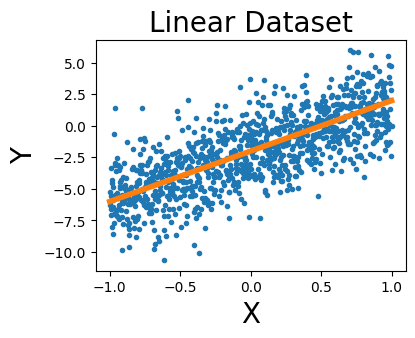

In [ ]:
### Plot the dataset
plt.figure(figsize=(4, 3))
plt.plot(x, y, '.')

### Plot the ground truth linear regressor
# print(x_range, x_range*gt_w+gt_b)
plt.plot(x_range, x_range*gt_w+gt_b, linewidth=4)

# ### Title and extras
plt.title('Linear Dataset', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

# Define the Pytorch Dataset with x y points
- Define your own class, which inherits from "Dataset" class of pytorch
- Define constructor of the class with `__init__`
- Define the length of the dataset with `__len__`
- Define the function when bringing out the idx-th dataset
    * Return the dictionary containing the input and output of single datapoint


In [ ]:
class XY_Dataset(Dataset):
    def __init__(self, x, y):
        '''
        x : input points
        y : output points
        '''
        self.x = x
        self.y = y
        self.num_data = x.shape[0]

        print("built new dataset!")

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['x'] = self.x[idx]
        sample['y'] = self.y[idx]

        # print("sampled {}-th element.".format(idx))

        return sample

In [ ]:
xy_dataset = XY_Dataset(x, y)
print(xy_dataset[5])

built new dataset!
{'x': -0.98998998998999, 'y': -3.365985975409521}


# Define the dataset, and dataloader
- DataLoader makes you to randomly sample the dataset with a batch size you want.

In [ ]:
### Define the batch size you want
batch_size = 4

### Create the instance of dataset, and dataloader
dataset = XY_Dataset(x, y)

# 0 1 2 3 4 5 ==> shuffle=True ==> 5 2 4 3 1 0 (Random shuffle)
# if batch size == 2
# (5, 2) (4, 3), (1, 0) batches will be returned from....
# for sample in dataloader:....
#     sample : (5,2), (4,3), (1,0)....

dataloader = DataLoader(dataset, batch_size, shuffle=True)

### Try sampling out one random data point.
sample = next(iter(dataloader))
print(sample['x'])
print(sample['x'].shape)

built new dataset!
tensor([-0.8498, -0.7838,  0.9019,  0.3954], dtype=torch.float64)
torch.Size([4])


# Initialize the weight and bias.

In [ ]:
### Needs requires_grad=True, if you want to make as a parameter to train.
pred_w = torch.randn(1, requires_grad=True)
pred_b = torch.randn(1, requires_grad=True)
print('Initialized w: {}, b: {}'.format(pred_w.item(), pred_b.item()))
print(pred_w)

Initialized w: -1.4211891889572144, b: -1.0442777872085571
tensor([-1.4212], requires_grad=True)


# Define the ,,train'' function.

In [ ]:
def train(pred_w, pred_b, sample, learning_rate):
    '''
    pred_w : weight to train.
    pred_b : bias to train.
    sample : sample from dataloader. dictionary containing 'x' and 'y'.
    learning_rate : the learning rate you want.
    pred_loss : predicted loss from this iteration
    '''

    # 1. get prediction
    pred_y = pred_w * sample['x'] + pred_b

    # 2. calculate the pred_loss
    criteria = nn.MSELoss()
    pred_loss = criteria(pred_y, sample['y'])
    # pred_loss = torch.norm(pred_y - sample['y']) / len(sample['x'])

    # 3. make pytorch compute the gradient
    pred_loss.backward()

    # 4. need ``no_grad'' to keep the computed gradient. otherwise, it will generate NoneType
    with torch.no_grad():
        pred_w -= learning_rate * pred_w.grad
        pred_b -= learning_rate * pred_b.grad

    # 5. initizlize the gradient to zero
    pred_w.grad.zero_()
    pred_b.grad.zero_()

    return pred_loss

# Iterate over the dataset! With your ,,train'' function

In [ ]:
# define the maximum epoch
max_epoch = 64

# define a list to save the loss
loss_saver = list()

# save the result in the middle
saved_w = []
saved_b = []

# iterate over the dataset for (max_epoch) times
for epoch in tqdm(range(max_epoch)):
    total_loss = 0.0
    for idx, sample in enumerate(dataloader):
        pred_loss = train(pred_w, pred_b, sample, learning_rate=1e-2)
        total_loss += pred_loss.item()/len(dataloader)

    loss_saver.append(total_loss)
    if np.log2(epoch+1) % 2 == 0:
        saved_w.append(pred_w.item())
        saved_b.append(pred_b.item())

        print('Epoch : {}, Loss : {}, pred_w : {}, pred_b : {}'.format(epoch+1, total_loss, pred_w.item(), pred_b.item()))

print()
print('Final Prediction : pred_w = {}, pred_b = {}'.format(pred_w.item(), pred_b.item()))

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 1, Loss : 6.737208583959449, pred_w : 2.8744373321533203, pred_b : -2.1309971809387207
Epoch : 4, Loss : 4.024809898201835, pred_w : 3.791506767272949, pred_b : -2.0989887714385986
Epoch : 16, Loss : 4.019933325497457, pred_w : 3.867175579071045, pred_b : -2.124077081680298
Epoch : 64, Loss : 4.016198702926107, pred_w : 3.8335695266723633, pred_b : -2.0273358821868896

Final Prediction : pred_w = 3.8335695266723633, pred_b = -2.0273358821868896


# Plot the result : training loss and resulted linear regressor

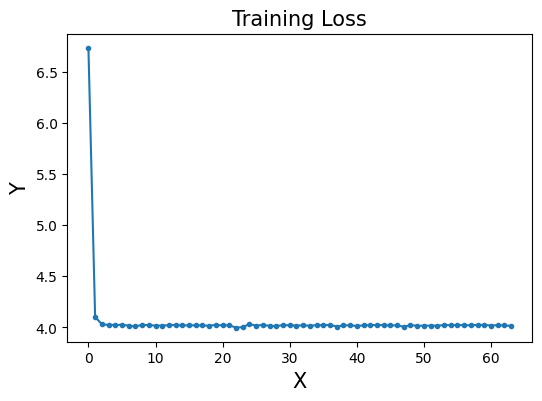

In [ ]:
loss_saver = np.array(loss_saver)
plt.figure(figsize=(6, 4))
plt.plot(np.arange(len(loss_saver)), loss_saver, '.-')
plt.title('Training Loss', fontsize=15)
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.show()

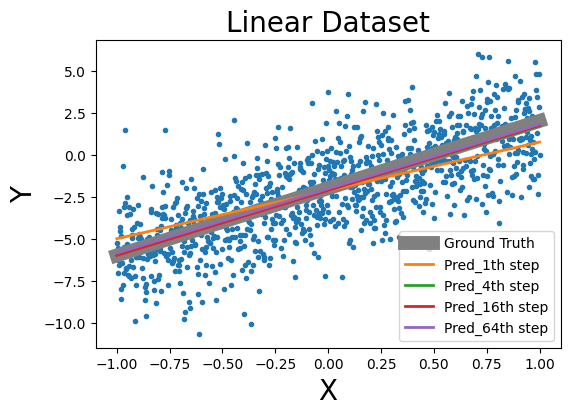

In [ ]:
plt.figure(figsize=(6, 4))

### Plot the dataset
plt.plot(x, y, '.')

### Plot the ground truth + predicted linear regressor
plt.plot(x_range, x_range*gt_w + gt_b, linewidth=10, color=[0.5, 0.5, 0.5], label='Ground Truth')

for idx, (w, b) in enumerate(zip(saved_w, saved_b)):
    plt.plot(x_range, x_range*w + b, linewidth=2, label='Pred_{}th step'.format(4**idx))

### Title and extras
plt.title('Linear Dataset', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.legend()
plt.show()